In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import json

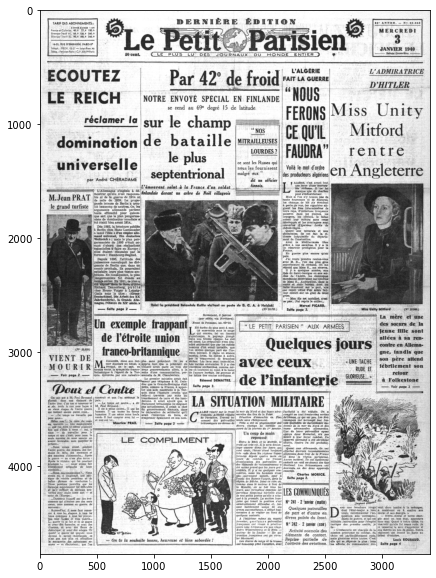

In [17]:
original = cv2.imread("data/full_set/bpt6k683902h_1.jpg", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(15, 10))
plt.imshow(original, cmap='gray')

In [4]:
# extracts a sub part of the image: returns a patch
def extract(img, i, j, w, h):
    return img[i:i+w, j:j+h]

# computes the fft of an image; returns the magnitude spectrum
def compute_fft(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift))
    # plt.figure(figsize=(15, 10))
    # plt.imshow(magnitude_spectrum)
    # plt.show()
    return fshift

# creates mask to focus on the halftone components of the magnitude spectrum
def create_mask(m,n):
    mask = np.zeros((m,n))
    radius = (m+n)//100
    a = int((n/4 + n/3)/2)
    b = int((m/4 + m/3)/2)
    cv2.circle(mask, (a,b), radius, 1, thickness=-1)
    cv2.circle(mask, (a,m-b), radius, 1, thickness=-1)
    cv2.circle(mask, (n-a,b), radius, 1, thickness=-1)
    cv2.circle(mask, (n-a,m-b), radius, 1, thickness=-1)
    return mask

In [19]:
THRESHOLD = 5                           # threshold for the binary halftone map
KERNEL1 = np.ones((20,20), np.uint8)    # kernel for closing
KERNEL2 = np.ones((30,30), np.uint8)    # kernel for opening
MIN_SIZE = 20000                        # minimum size for a connected component to be kept

img = original.copy()

def segmentation(img):

    mask = create_mask(*img.shape)

    f = compute_fft(img)
    masked_f = f * mask

    # create halftone map based on image reconstruction from the masked fft
    halftone_map = np.abs(np.fft.ifft2(np.fft.ifftshift(masked_f)))

    # plt.figure(figsize=(15, 10))
    # plt.imshow(halftone_map)
    # plt.show()

    # select the values abobe THRESHOLD
    halftone_map_bin = (halftone_map > THRESHOLD).astype(np.uint8)

    # plt.figure(figsize=(15, 10))
    # plt.imshow(halftone_map_bin)
    # plt.show()

    # apply morphological closing
    halftone_map_bin = cv2.morphologyEx(halftone_map_bin.astype(np.uint8), cv2.MORPH_CLOSE, KERNEL1)

    # plt.figure(figsize=(15, 10))
    # plt.imshow(halftone_map_bin)
    # plt.show()

    # apply morphological opening
    halftone_map_bin = cv2.morphologyEx(halftone_map_bin.astype(np.uint8), cv2.MORPH_OPEN, KERNEL2)

    # plt.figure(figsize=(15, 10))
    # plt.imshow(halftone_map_bin)
    # plt.show()

    # label the connected components in the halftone map
    _, labels = cv2.connectedComponents(halftone_map_bin)

    # remove small connected components
    sizes = np.bincount(labels.flatten())
    for i in range(1, len(sizes)):
        if sizes[i] < MIN_SIZE:
            labels[labels == i] = 0

    # compute the bounding boxes of the remaining connected components
    bounding_boxes = []
    for i in range(1, labels.max()+1):
        cc_mask = (labels == i).astype(np.uint8)
        if(np.max(cc_mask) > 0):
            bounding_boxes.append(cv2.boundingRect(cc_mask))
    
    return halftone_map_bin, bounding_boxes

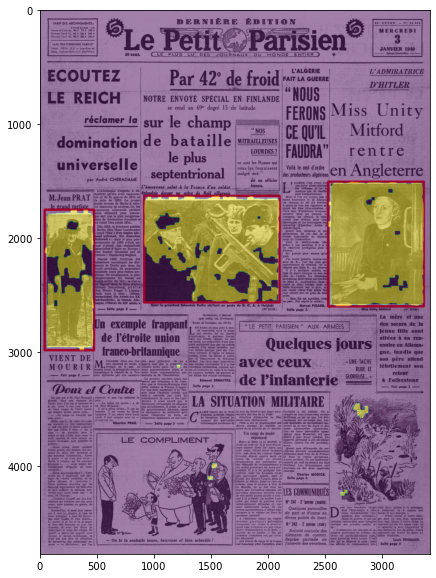

In [20]:
# displays the halftone map and the bouding boxes on the original image

img = original.copy()

halftone_map_bin, bounding_boxes = segmentation(img)
print(bounding_boxes)

image_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
for x, y, w, h in bounding_boxes:
    cv2.rectangle(image_rgb, (x, y), (x+w, y+h), (255, 0, 0), 20)

plt.figure(figsize=(15, 10))
plt.imshow(image_rgb, cmap='gray')
plt.imshow(halftone_map_bin, alpha=.5)
plt.show()

## Segmentation on test set

### Segmentation of the photos

In [22]:
FOLDER_INPUT = 'data/full_set'
FOLDER_EXTRACTION = 'output/full_set/global/extraction'
FOLDER_DRAFT = 'output/full_set/global/draft'
FILE_SEGMENTATION = 'output/full_set/global/segmentation.csv'
FILE_GROUNDTRUTH = 'data/full_set/bb_groundtruth_non_empty.csv'

In [23]:
with open(FILE_SEGMENTATION, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes'])

    for filename in os.listdir(FOLDER_INPUT):
        if filename.endswith('.jpg'):
            image_path = os.path.join(FOLDER_INPUT, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            file_size = os.path.getsize(image_path)
            
            halftone_map_bin, bounding_boxes = segmentation(image)

            # image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

            # if there are no bounding boxes in the image, write an empty row
            if len(bounding_boxes) == 0:
                writer.writerow([filename, file_size, "{}", 0, "{}", "{}", "{}"])
            else:
                for region_id, (x, y, w, h) in enumerate(bounding_boxes):
                    region_shape_attributes = f'{{"name":"rect","x":{x},"y":{y},"width":{w},"height":{h}}}'
                    writer.writerow([filename, file_size, "{}", len(bounding_boxes), region_id, region_shape_attributes, "{}"])
                    # cv2.rectangle(image_rgb, (x, y), (x+w, y+h), (255, 0, 0), 20)
            
            # plt.figure(figsize=(10, 15))
            # plt.imshow(image_rgb, cmap='gray')
            # plt.imshow(halftone_map_bin, alpha=.5)
            # plt.savefig(os.path.join(FOLDER_DRAFT, filename))

   
            print(filename, len(bounding_boxes))

bpt6k683937f_4.jpg 1
bpt6k684110w_1.jpg 0
bpt6k683962k_3.jpg 0
bpt6k683942w_2.jpg 1
bpt6k6840567_1.jpg 2
bpt6k683903w_5.jpg 3
bpt6k683919h_2.jpg 0
bpt6k6840834_2.jpg 0
bpt6k684067z_2.jpg 0
bpt6k683955c_3.jpg 0
bpt6k683926q_1.jpg 3
bpt6k6840923_2.jpg 0
bpt6k6842276_2.jpg 1
bpt6k684196x_2.jpg 0
bpt6k6840054_2.jpg 0
bpt6k6842106_3.jpg 0
bpt6k683963z_2.jpg 1
bpt6k684190n_4.jpg 3
bpt6k6839048_2.jpg 0
bpt6k684072d_2.jpg 0
bpt6k684228k_2.jpg 2
bpt6k684229z_2.jpg 3
bpt6k684034s_3.jpg 0
bpt6k6839438_1.jpg 4
bpt6k6839697_1.jpg 4
bpt6k683953m_4.jpg 1
bpt6k6839663_2.jpg 1
bpt6k6840656_1.jpg 4
bpt6k684198p_4.jpg 1
bpt6k6841691_3.jpg 0
bpt6k683980h_2.jpg 0
bpt6k6841199_2.jpg 0
bpt6k6839485_2.jpg 0
bpt6k684040m_2.jpg 1
bpt6k6840533_1.jpg 3
bpt6k6841691_2.jpg 2
bpt6k684223p_4.jpg 2
bpt6k683990v_5.jpg 0
bpt6k6842318_2.jpg 1
bpt6k684207h_2.jpg 2
bpt6k684159p_1.jpg 6
bpt6k684100j_1.jpg 1
bpt6k684163r_1.jpg 4
bpt6k684179c_1.jpg 5
bpt6k684004r_2.jpg 1
bpt6k683917r_4.jpg 0
bpt6k683997h_4.jpg 1
bpt6k6841508_

### Evaluation of the segmentation

In [37]:
# intersection over union metric
def iou(bb1, bb2):

    if bb1 == "{}" and bb2 == "{}":
        return 1
    elif bb1 == "{}" or bb2 == "{}":
        return 0

    _, x1, y1, w1, h1 = json.loads(bb1).values()
    _, x2, y2, w2, h2 = json.loads(bb2).values()

    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = w1 * h1
    boxBArea = w2 * h2

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


# reads the groundtruth csv file
def read_csv(file):
    data = {}
    with open(file, mode='r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            filename, file_size, file_attributes, region_count, region_id, region_shape_attributes, region_attributes = row
            if filename not in data:
                data[filename] = []
            data[filename].append(region_shape_attributes)
    return data


# computes the IoU between two sets of bounding boxes
def compute_iou(bb1, bb2):
    iou_sum = 0
    non_zero = 0
    for i in range(len(bb1)):
        for j in range(len(bb2)):
            res = iou(bb1[i], bb2[j])
            if res > 0:
                non_zero += 1
            iou_sum += res
    if non_zero == 0:
        return 0
    return iou_sum / non_zero

bpt6k6841780_2.jpg 0.9508993973226122
bpt6k6841767_4.jpg 0.27416948593827883
bpt6k6841644_4.jpg 0.9098400491738876
bpt6k6841610_1.jpg 0.6712098712842058
bpt6k6839697_1.jpg 0.9676557752806982
bpt6k6839663_4.jpg 0.9022097666228516
bpt6k6839451_4.jpg 0.9669222416368557
bpt6k6839451_1.jpg 0.9670801138439223
bpt6k6839150_1.jpg 0.9607684967055047
bpt6k684232n_2.jpg 0.9547623750171584
bpt6k684221x_1.jpg 0.5625604905270044
bpt6k684202m_4.jpg 0.9188565440642802
bpt6k684189q_1.jpg 0.9605729350804078
bpt6k684184t_4.jpg 0.9931273942066922
bpt6k684171b_2.jpg 0.963044650296525
bpt6k684165h_4.jpg 0.9341075691021313
bpt6k684160m_4.jpg 0.9255709169796635
bpt6k684157x_2.jpg 0.909883727301182
bpt6k684153d_4.jpg 0.8623387907592412
bpt6k684153d_1.jpg 0.9455776128456809
bpt6k684006h_3.jpg 0.9799414747632637
bpt6k683997h_1.jpg 0.9605400479218063
bpt6k683983n_5.jpg 0.9827395303866338
bpt6k683974p_1.jpg 0.9740664158479566
bpt6k683958h_1.jpg 0.9743619341164761
bpt6k683951v_1.jpg 0.9553582093980183
bpt6k683942w_

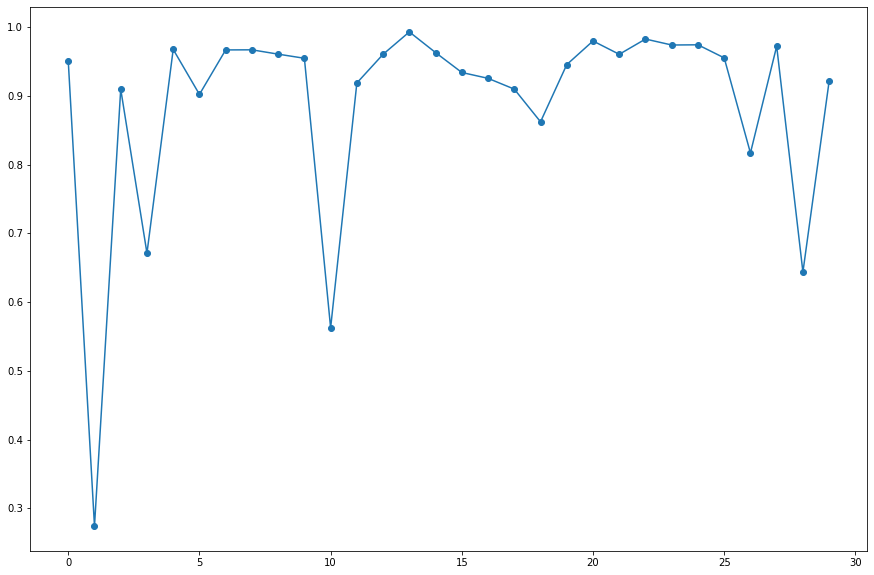

In [46]:
bb_groundtruth = read_csv(FILE_GROUNDTRUTH)
bb_segmentation = read_csv(FILE_SEGMENTATION)

iou_values = []
for filename in bb_groundtruth:
    iou_val = compute_iou(bb_groundtruth[filename], bb_segmentation[filename])
    print(filename, iou_val)
    iou_values.append(iou_val)

iou_avg = np.mean(iou_values)
iou_min = np.min(iou_values)
iou_max = np.max(iou_values)
iou_quantiles = np.percentile(iou_values, [25, 50, 75])

print("\nAverage IOU:", iou_avg)
print("Min IOU:", iou_min)
print("Max IOU:", iou_max)
print("25th, 50th, 75th Quantiles:", iou_quantiles)

plt.figure(figsize=(15, 10))
plt.plot(iou_values, '-o')
plt.show()

### Extraction of the photos

In [24]:
with open(FILE_SEGMENTATION, mode='r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        filename, file_size, file_attributes, region_count, region_id, region_shape_attributes, region_attributes = row
        if region_count == '0':
            continue
        _, x, y, w, h = json.loads(region_shape_attributes).values()
        image = cv2.imread(f'{FOLDER_INPUT}/{filename}', cv2.IMREAD_GRAYSCALE)
        photo = extract(image, y, x, h, w)
        cv2.imwrite(f'{FOLDER_EXTRACTION}/{filename[:-4]}_{x}_{y}_{w}_{h}.jpg', photo)

        print(filename, x, y, w, h)

bpt6k683937f_4.jpg 1786 385 382 673
bpt6k683942w_2.jpg 128 2271 307 80
bpt6k6840567_1.jpg 2567 954 805 1113
bpt6k6840567_1.jpg 1758 2177 1181 919
bpt6k683903w_5.jpg 2976 3312 397 366
bpt6k683903w_5.jpg 573 4463 298 187
bpt6k683903w_5.jpg 1564 4506 267 155
bpt6k683926q_1.jpg 2563 1320 775 967
bpt6k683926q_1.jpg 72 1446 1198 723
bpt6k683926q_1.jpg 1702 1607 430 805
bpt6k6842276_2.jpg 1462 293 531 788
bpt6k683963z_2.jpg 191 2434 286 88
bpt6k684190n_4.jpg 965 297 810 546
bpt6k684190n_4.jpg 1798 1727 401 603
bpt6k684190n_4.jpg 559 2280 811 402
bpt6k684228k_2.jpg 2588 165 819 845
bpt6k684228k_2.jpg 112 1649 392 517
bpt6k684229z_2.jpg 1762 1369 219 280
bpt6k684229z_2.jpg 2675 1399 324 281
bpt6k684229z_2.jpg 2192 2120 400 425
bpt6k6839438_1.jpg 1705 1506 834 860
bpt6k6839438_1.jpg 51 3038 411 929
bpt6k6839438_1.jpg 48 3487 161 483
bpt6k6839438_1.jpg 1299 3988 829 758
bpt6k6839697_1.jpg 2571 1410 818 838
bpt6k6839697_1.jpg 1329 1858 420 816
bpt6k6839697_1.jpg 86 2232 396 849
bpt6k6839697_1.jpg 